<a href="https://colab.research.google.com/github/zdanielm/halado-nlp-projekt/blob/main/NLP_Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A projekt célja
Egy olyan AI összeállítása/fejlesztése amely képes összegyűjtött tőzsdei algoritmusok közül a legjobbat kiválasztani, valamint elmagyarázni az erősségeit és gyengeségeit az adott tőzsdei algoritmusnak.

A 8000 kalória csapattagjai:
- Zombori Dániel
- Pál Erik
- Sándor Martin
- Nyeste Balázs


# Adatok Beolvasása

Az adatot google drive-ról olvassuk, be hogy közösen tudjunk dolgozni, valamint az adatok tartósan tárolódjanak

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.getcwd())


/content


In [ ]:
all_data = []

for file in os.listdir("/content/drive/MyDrive/algoritmusok"):
  with open("/content/drive/MyDrive/algoritmusok/" + file, "r") as f:
    all_data.append(f.read())

all_data

['# Name: Simple Dynamic Momentum\n# Data type: Backtesting data\n# Equity: $152,342.04\n# Fees: -$259.35\n# Holdings: $155,254.07\n# Net Profit: $33,611.72\n# PSR: 14.488%\n# Return: 52.34 %\n# Unrealized: $18,725.15\n# Volume: $2,414,731.77\n\n##### main.py #####\n# region imports\nfrom AlgorithmImports import *  # Import QuantConnect base classes and functions\nfrom scipy.stats import linregress  # For linear regression used in momentum calculation\nimport numpy as np  # Used for numerical operations, especially log transformation\n# endregion\n\nclass SimpleDynamicMomentumAlgorithm(QCAlgorithm):\n    def Initialize(self):\n        self.SetStartDate(2021, 1, 1)  # Set start date for backtest\n        self.SetEndDate(datetime.now())  # Set end date to today for live/backtest parity\n        self.SetCash(1000000)  # Set initial capital for trading\n\n        # Define a list of large-cap tech stocks to trade\n        self.symbols = [self.AddEquity(ticker, Resolution.Daily).Symbol for t

Algoritmusok beolvasása, a beolvasott adatok 30 DB tőzsdében használt algoritmust tartalmaznak

Pandas Dataframe-t készítünk az adatokból a későbbi könyebb feldolgozás érdekében

In [ ]:
# prompt: create a new pandas Dataframe from the data list

import pandas as pd

df = pd.DataFrame(all_data, columns=['content'])
df


,content
0,# Name: Simple Dynamic Momentum\n# Data type: ...
1,#Name: Standardized Unexpected Earnings\n#Data...
2,# Name: Trend-Optimized Allocation\n# Data typ...
3,# Name: FX Statistical Arbitrage\n# Data type:...
4,# Name: All-Weather Portfolio\n# Data type: Li...
5,# Name: VWMA-ROC Momentum (Temporary)\n# Data ...
6,# Name: Quiver Quant Crowd Sentiment\n# Data t...
7,# Name: Intraday Momentum\n# Data type: Backte...
8,# Name: Factor Sector Rotation\n# Data type: L...
9,# Name: Sector Momentum Exploit\n# Data type: ...


## Szeletelés és felbontás

Ahhoz, hogy könyebben emészthetővé és vektorizálhatóvá tegyük az adatot a Tokenizer számára, felbontjuk szavakra, szó számokra és hosszra az adatot, majd a túlzottan hosszú adatokat eldobjuk, mivel nem biztosm hogy ezeket képesek leszünk feldolgozni a korlátozott erőforrások miatt.

In [ ]:
# prompt: break the content to words into another column and put the word's total lengths of them into another column

df['words'] = df['content'].str.split()
df['word_count'] = df['words'].str.len()
df['total_word_length'] = df['words'].apply(lambda x: sum(len(word) for word in x) if isinstance(x, list) else 0)

df


,content,words,word_count,total_word_length
0,# Name: Simple Dynamic Momentum\n# Data type: ...,"[#, Name:, Simple, Dynamic, Momentum, #, Data,...",664,4689
1,#Name: Standardized Unexpected Earnings\n#Data...,"[#Name:, Standardized, Unexpected, Earnings, #...",945,8633
2,# Name: Trend-Optimized Allocation\n# Data typ...,"[#, Name:, Trend-Optimized, Allocation, #, Dat...",798,6038
3,# Name: FX Statistical Arbitrage\n# Data type:...,"[#, Name:, FX, Statistical, Arbitrage, #, Data...",1202,9616
4,# Name: All-Weather Portfolio\n# Data type: Li...,"[#, Name:, All-Weather, Portfolio, #, Data, ty...",1047,9117
5,# Name: VWMA-ROC Momentum (Temporary)\n# Data ...,"[#, Name:, VWMA-ROC, Momentum, (Temporary), #,...",573,4478
6,# Name: Quiver Quant Crowd Sentiment\n# Data t...,"[#, Name:, Quiver, Quant, Crowd, Sentiment, #,...",1007,10007
7,# Name: Intraday Momentum\n# Data type: Backte...,"[#, Name:, Intraday, Momentum, #, Data, type:,...",634,4977
8,# Name: Factor Sector Rotation\n# Data type: L...,"[#, Name:, Factor, Sector, Rotation, #, Data, ...",752,6739
9,# Name: Sector Momentum Exploit\n# Data type: ...,"[#, Name:, Sector, Momentum, Exploit, #, Data,...",659,6474


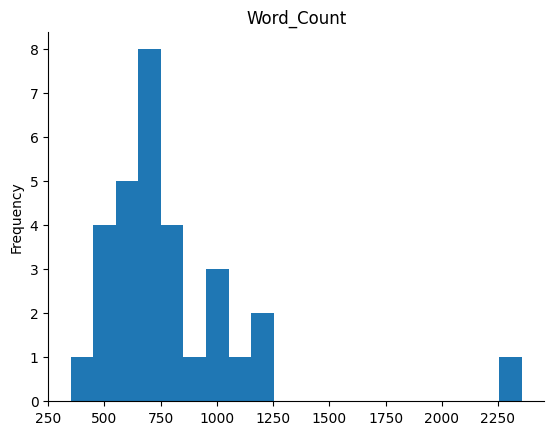

In [ ]:
import matplotlib.pyplot as plt

df['word_count'].plot(kind='hist', bins=20, title='Word_Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

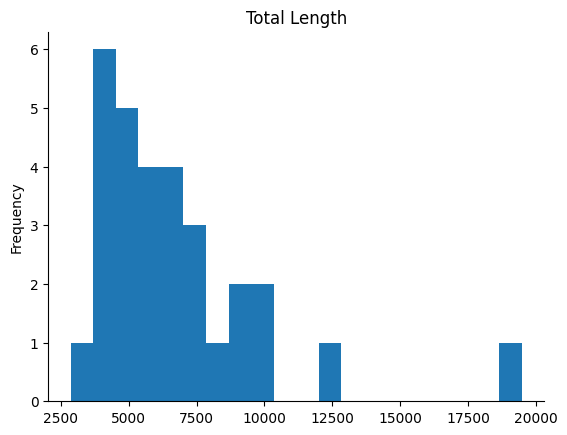

In [ ]:
df['total_word_length'].plot(kind='hist', bins=20, title='Total Length')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.describe()

,word_count,total_word_length
count,30.000000,30.000000
mean,790.800000,6719.566667
std,365.976672,3286.232983
min,350.000000,2867.000000
25%,588.000000,4700.500000
50%,688.000000,5971.500000
75%,913.000000,7697.500000
max,2355.000000,19469.000000


# Adat kiegyensúlyozása

Az 1250 szónál és 10000 karakternél hosszabb adatokat eldobjuk, ugyanis feldolgozásuk komoly erőforrásokat venne igénybe és hogy az AI számára kiegyensúlyozottabb ugyanolyan értékkel biró adatokat adjunk át.

In [ ]:
#Balanszoljuk az adatot

# prompt: Drop rows that are bigger than 1250 word_count and bigger than 10000 total_word_length

# Drop rows based on conditions
df = df[(df['word_count'] <= 1250) & (df['total_word_length'] <= 10000)]

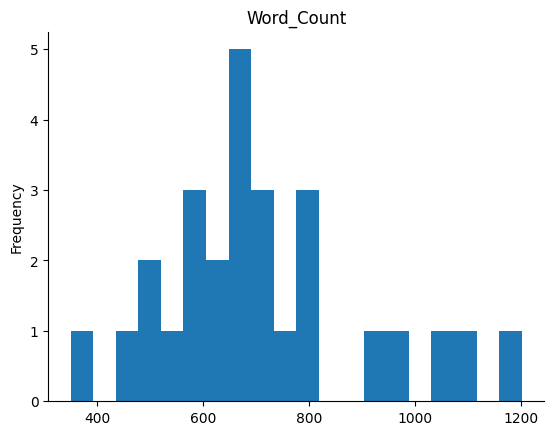

In [ ]:
df['word_count'].plot(kind='hist', bins=20, title='Word_Count')
plt.gca().spines[['top', 'right',]].set_visible(False)

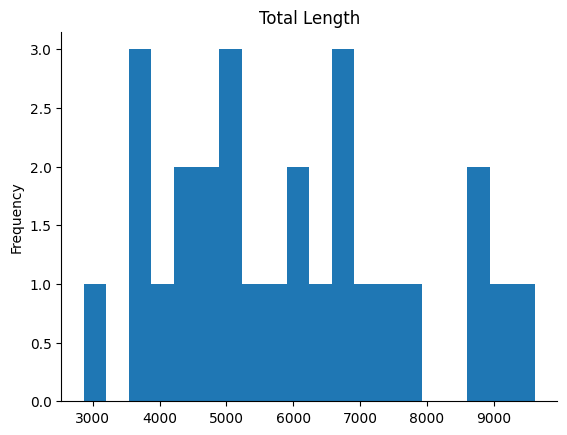

In [ ]:
df['total_word_length'].plot(kind='hist', bins=20, title='Total Length')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.describe()

,word_count,total_word_length
count,27.000000,27.000000
mean,709.148148,5904.296296
std,199.114328,1820.539244
min,350.000000,2867.000000
25%,574.000000,4583.500000
50%,673.000000,5575.000000
75%,797.500000,6926.000000
max,1202.000000,9616.000000


# Vektoradatbázis felépítése

In [ ]:
!pip install llama-index llama-index-embeddings-huggingface llama-index-llms-huggingface bitsandbytes sentence_transformers langchain --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.5/438.5 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.1/361.1 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.3/267.3 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.9/583.9 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.5/720.5 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from tqdm import tqdm

from llama_index.core import Settings
from llama_index.core import Document
from llama_index.core import StorageContext
from llama_index.core import VectorStoreIndex
from llama_index.core import load_index_from_storage
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

In [ ]:
# !pip install llama-cpp-python --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 MB 18.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.8 MB/s eta 0:00:00


In [ ]:
corpus_list = df['content'].tolist()

## Próbált embedding modellek:
- microsoft/codebert-base
    - Bár azt mondták, hogy embedding modell, de nem az, az alapértelmezett mean poolingot használta volna.
- nomic-ai/nomic-embed-code
    - Túl nagy modellméret és embedding dimenziók, a TPU-t rosszabbul kezeli a többiekhez képest.
- intfloat/e5-base-v2
    - Regularizált embedding modell, de állítólag elég jól kezeli a kódot.
    - Előnye: méret
- jinaai/jina-embeddings-v2-base-code
    - A legjobb a embedding dimenziók és a modell mérete alapján, és kódra specializált.


In [ ]:
#model_name = "intfloat/e5-base-v2"
model_name = "jinaai/jina-embeddings-v2-base-code"

Settings.llm = None
Settings.embed_model = HuggingFaceEmbedding(model_name=model_name)

LLM is explicitly disabled. Using MockLLM.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.44k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/322M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at jinaai/jina-embeddings-v2-base-code and are newly initialized: ['embeddings.position_embeddings.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.1.intermediate.dense.bias', 'encoder.layer.1.intermediate.dense.weight', 'encoder.layer.1.output.LayerNorm.bias', 'encoder.layer.1.output.LayerNorm.weight', 'encoder.layer.1.output.dense.bias', 'encoder.layer.1.output.dense.weight', 'encoder.layer.10.intermediate.dense.bias', 'encoder.layer.10.intermediate.dense.weight', 'encoder.layer.10.output.LayerNorm.bias', 'encoder.layer.10.output.LayerNorm.weight', 'encoder.layer.10.output.dense.bias', 'encoder.layer.10.output.dense.weight', 'encoder.layer.11.intermediate.dense.bias', 'encoder.layer.11.interme

tokenizer_config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/971k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [ ]:
#model_name = "nomic-ai/nomic-embed-code"

#Settings.llm = None
#Settings.embed_model = HuggingFaceEmbedding(model_name=model_name)

LLM is explicitly disabled. Using MockLLM.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
#from langchain.text_splitter import RecursiveCharacterTextSplitter

#splitter = RecursiveCharacterTextSplitter(
#    chunk_size=512,
#    chunk_overlap=50,
#    separators=["\nclass ", "\ndef ", "\n\n", "\n"]
#)

#documents = []
#for i, code in tqdm(enumerate(corpus_list)):
#    chunks = splitter.split_text(code)
#    for chunk in chunks:
#      documents.append(Document(text=chunk))
#
#len(documents)

27it [00:00, 2266.96it/s]


612

In [ ]:
!pip install llama3.2-token-counter --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.5/320.5 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.9/781.9 kB 45.4 MB/s eta 0:00:00


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from llama_token_counter import LlamaTokenCounter

# Llama 3.2-specifikus token counter
counter = LlamaTokenCounter()

def llama_token_counter(text):
    return counter.count_tokens_sync(text)

splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,  # Tokenek (nem karakterek a length_function paraméter miatt)
    chunk_overlap=40,  # 20% a chunk_size-nak
    separators=["\nclass ", "\ndef ", "\n\n", "\n", " "],
    length_function=llama_token_counter
)

documents = []
for i, code in tqdm(enumerate(corpus_list)):
    chunks = splitter.split_text(code)
    for chunk in chunks:
      documents.append(Document(text=chunk))

len(documents)


27it [00:00, 45.17it/s]


468

In [ ]:
index = VectorStoreIndex.from_documents(documents, show_progress=True, insert_batch_size=len(documents))

Parsing nodes:   0%|          | 0/468 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/468 [00:00<?, ?it/s]

## Ágens

In [ ]:
!pip install huggingface_hub torch_xla --quiet

In [ ]:
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core.memory import ChatMemoryBuffer
import torch

## RAG-nál próbált LLM-ek:
- meta-llama/Llama-3.2-1B-Instruct
    - Jól működött, de ki akartunk próbálni kódspecifikus modelleket is
- meta-llama/CodeLlama-7b-hf
- meta-llama/CodeLlama-7b-Python-hf
    - A általánosított CodeLLama kipróbálása után kipróbáltuk a Python kódra specializáltat is

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from huggingface_hub import login
from google.colab import userdata

login(token=userdata.get('LLamaAPIKey'))
login(token=userdata.get('CodeLLamaAPIKey'))

In [ ]:
llm_model = "meta-llama/CodeLlama-7b-Python-hf"

In [ ]:
# Létrehozzuk a nyelvi modellt (LLM), amit az ágens fog használni.
llm = HuggingFaceLLM(
    model_name=llm_model,       # Nyelvi modell beállítása
    tokenizer_name=llm_model,   # Nyelvi modell tokenizátorának beállítása
    context_window=32000,                                          # Maximum token limit
    max_new_tokens=2048,                                           # Válasz maximális hossza
    #device_map=device,                                          # GPU használata,
    generate_kwargs={"temperature": 0.85, "do_sample": True},     # Ezek a paraméterek befolyásolják a modell válaszainak véletlenszerűségét és kreativitását.
    #model_kwargs={"torch_dtype": torch.bfloat16}     # Bfloat16 Float32 helyett
)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00001-of-00002.safetensors:  44%|####3     | 7.77G/17.7G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

In [ ]:
# Létrehozzuk a chat motort, ami az ágens párbeszédéért felelős.
chat_engine = index.as_chat_engine(
    # Ez a paraméter beállítja, hogy a chat motor a korábban létrehozott vektoradatbázist használja a válaszokhoz.
    chat_mode="context",
    #chat_mode="condense_plus_context",
    # Ez a paraméter beállítja a chat motor memóriáját. A ChatMemoryBuffer emlékszik a korábbi beszélgetésekre.
    memory=ChatMemoryBuffer.from_defaults(token_limit=32000),
    verbose=True,
    system_prompt=(
        "You are a stock market coder professional who always responds with the best solution for trading questions! Answer mostly based on the dataset! Also always explain your choice and assist with as much code as possible!"
    )
)

In [ ]:
!pip install gradio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 131.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.6 MB/s eta 0:00:00


In [ ]:
import gradio as gr

# Chat memória reset funkció
def reset_memory():
    chat_engine.reset()
    return gr.update(value="Memória törölve. Új lekérdezés indítható.")

# Fő beszélgetési függvény
def chat_with_agent(user_input, history):
    if user_input.lower() == "reset":
        return reset_memory(), []

    try:
        response = chat_engine.stream_chat(user_input)
        full_response = ""
        for token in response.response_gen:
            full_response += token
        history.append((user_input, full_response))
        return "", history
    except Exception as e:
        return f"[Hiba történt]: {e}", history

# Gradio interfész létrehozása
with gr.Blocks() as demo:
    gr.Markdown("## 💬 Tőzsdei Chatbot - LLM Ágenssel")
    chatbot = gr.Chatbot(label="💼 Chatbot válaszai")#.style(height=400)
    with gr.Row():
        txt = gr.Textbox(show_label=False, placeholder="Írj ide...")#.style(container=False)
        send_btn = gr.Button("📤 Küldés")
        reset_btn = gr.Button("🔄 Memória Reset")

    # Gomb események
    send_btn.click(chat_with_agent, inputs=[txt, chatbot], outputs=[txt, chatbot])
    txt.submit(chat_with_agent, inputs=[txt, chatbot], outputs=[txt, chatbot])
    reset_btn.click(fn=reset_memory, outputs=[txt])

# Interfész indítása
demo.launch(share=True)

<ipython-input-24-b2c85cbeb993>:26: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="💼 Chatbot válaszai")#.style(height=400)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://688528ad5e0c0e60f3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
while True:
    try:
        query = input("> ")
        if query.lower() == "quit":
            break
        if query.lower() == "reset":
            chat_engine.reset()
            print("💾 Memória törölve.")
            continue

        print("Agent: ", end="", flush=True)
        response = chat_engine.stream_chat(query)
        for token in response.response_gen:
            print(token, end="", flush=True)
        print()
    except Exception as e:
        print(f"\n[Hiba történt]: {e}")

> How to calculate the change in quarterly EPS?
Agent: system: Use the context information below to assist the user.
--------------------
# Get historical data to warm up indicators
    history = algorithm.history[consolidator.input_type](security.symbol, lookback, resolution,
        data_normalization_mode = DataNormalizationMode.SCALED_RAW)

del self.entry_prices[symbol]
                    del self.highest_prices[symbol]
--------------------
You are a stock market coder professional who always responds with the best solution for trading questions! Answer mostly based on the dataset! Also always explain your choice and assist with as much code as possible!
user: How to calculate the change in quarterly EPS?
assistant: 
> What is the best algorithm based on live data?
Agent: system: Use the context information below to assist the user.
--------------------
# Get historical data to warm up indicators
    history = algorithm.history[consolidator.input_type](security.symbol, lookback, r

## Index perzisztálása

In [ ]:
!pip install huggingface_hub --quiet

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
#from huggingface_hub import create_repo

#create_repo("zdanielm/nlp-faiss", private=True)

RepoUrl('https://huggingface.co/zdanielm/nlp-faiss', endpoint='https://huggingface.co', repo_type='model', repo_id='zdanielm/nlp-faiss')

In [ ]:
persist_dir = "index_storage"
index.storage_context.persist(persist_dir=persist_dir)

In [ ]:
from huggingface_hub import upload_file

repo_id = "zdanielm/nlp-faiss"

for filename in os.listdir(persist_dir):
    file_path = os.path.join(persist_dir, filename)
    upload_file(
        path_or_fileobj=file_path,
        path_in_repo=f"index/{filename}",
        repo_id=repo_id,
    )

default__vector_store.json:   0%|          | 0.00/8.21M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


## Ezután már nem kell újra felépíteni, csak importálni

In [ ]:
from huggingface_hub import snapshot_download
import os

# Step 1: Define a persistent local path
local_data_path = snapshot_download(
    repo_id="zdanielm/nlp-faiss",
    local_dir="./hf_cache",
    local_dir_use_symlinks=False
)

persist_dir = os.path.join(local_data_path, "index")
print("Persist dir:", persist_dir)

storage_context = StorageContext.from_defaults(persist_dir=persist_dir)
index = load_index_from_storage(storage_context)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:980: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Persist dir: /content/hf_cache/index


# Tokenizálás és alap LM felépítése

Az adatokat listává alakítjuk, majd a szótőréseket megjelöljük.

In [ ]:
corpus_list = df['content'].tolist()

corpus = "\n".join(corpus_list)

corpus

'#Name: Standardized Unexpected Earnings\n#Data type: Live data\n#Equity: $1,367,460.29\n#Fees: -$89.29\n#Holdings: $1,362,480.66\n#Net Profit: $385,848.70\n#PSR: 0%\n#Return: 5.92 %\n#Unrealized: -$124,619.64\n#Volume: $4,675,162.55\n\n##### main.py #####\n#region imports\nfrom AlgorithmImports import *\n\nfrom universe import TopStandardizedUnexpectedEarningsUniverseSelectionModel\nfrom alpha import MonthlyLongAlphaModel\n#endregion\n\n\nclass StandardizedUnexpectedEarningsAlgorithm(QCAlgorithm):\n    \'\'\'Step 1. Calculate the change in quarterly EPS from its value four quarters ago\n       Step 2. Calculate the st dev of this change over the prior eight quarters\n       Step 3. Get standardized unexpected earnings (SUE) from dividing results of step 1 by step 2\n       Step 4. Each month, sort universe by SUE and long the top quantile\n       \n       Reference:\n       [1] Foster, Olsen and Shevlin, 1984, Earnings Releases, Anomalies, and the Behavior of Security Returns,\n      

# ReRanking Model

Mivel 30 algoritmus közül kell választani, ez tömérdek mennyiségű tokenszám lenne egy reasoning modell számára, így egy Rerankink modell segítségével előszűrűnk és kiválasztjuk a top 3-at.
A State of the art Reranking modellnek köszönhetően kérdést alapján osztályozni tudjuk az algoritmusokat, valamint egy biztossági értéket is kapunk az adatok mellé, hogy mennyire biztos a választásában.

In [ ]:
import torch
torch.cuda.empty_cache()

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
#https://huggingface.co/mixedbread-ai/mxbai-rerank-base-v2

!pip install mxbai-rerank
!pip install transformers
!pip install --upgrade sympy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 54.0 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cpu requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.13.3 which is incompatible.


In [ ]:
from mxbai_rerank import MxbaiRerankV2

model = MxbaiRerankV2("mixedbread-ai/mxbai-rerank-base-v2")

query = "Which algorithm is the best for Stock Trading?"

results = model.rank(query, corpus_list, return_documents=True, top_k=3)

print(results)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `eager`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


[RankResult(index=8, score=4.644186973571777, document='# Name: Simple Dynamic Momentum\n# Data type: Backtesting data\n# Equity: $3,149,762.69\n# Fees: -$1,287.86\n# Holdings: $3,113,540.85\n# Net Profit: $1,189,801.22\n# PSR: 67.680%\n# Return: 214.98 %\n# Unrealized: $959,898.14\n# Volume: $37,929,012.50\n\n##### main.py #####\n# region imports\nfrom AlgorithmImports import *       # QuantConnect framework imports\nfrom scipy.stats import linregress  # For calculating regression slope (momentum)\nimport numpy as np                  # For numerical operations\n# endregion\n\nclass SimpleDynamicMomentumAlgorithm(QCAlgorithm):\n    def Initialize(self):\n        # Algorithm configuration - sets up time frame and initial capital\n        self.SetStartDate(2021, 1, 1)  # Set start date\n        self.SetEndDate(datetime.now())  # Set end date\n        self.SetCash(1000000)  # Set initial capital ($1M)\n\n        # Define the universe of assets - top tech stocks\n        self.symbols = [se

In [ ]:
type(results[0].document)
docs = [result.document for result in results]
docs[0]

'# Name: Simple Dynamic Momentum\n# Data type: Backtesting data\n# Equity: $3,149,762.69\n# Fees: -$1,287.86\n# Holdings: $3,113,540.85\n# Net Profit: $1,189,801.22\n# PSR: 67.680%\n# Return: 214.98 %\n# Unrealized: $959,898.14\n# Volume: $37,929,012.50\n\n##### main.py #####\n# region imports\nfrom AlgorithmImports import *       # QuantConnect framework imports\nfrom scipy.stats import linregress  # For calculating regression slope (momentum)\nimport numpy as np                  # For numerical operations\n# endregion\n\nclass SimpleDynamicMomentumAlgorithm(QCAlgorithm):\n    def Initialize(self):\n        # Algorithm configuration - sets up time frame and initial capital\n        self.SetStartDate(2021, 1, 1)  # Set start date\n        self.SetEndDate(datetime.now())  # Set end date\n        self.SetCash(1000000)  # Set initial capital ($1M)\n\n        # Define the universe of assets - top tech stocks\n        self.symbols = [self.AddEquity(ticker, Resolution.Daily).Symbol for ticke

Az adatokat lementjük, hogy később egy Reasoning modell segítségével feldolgozzuk és kérdezzünk belőle

In [ ]:
# prompt: save the results to the drive with the name results.txt
import json

with open('/content/drive/MyDrive/results.txt', 'w') as f:
    json.dump(docs,f)

# Reasoning Modell
Az előszűrt algoritmusokat átadjuk egy Reasoning modellnek, a mi esetünkben 1B paraméterrel rendelkező LLama 3.2-es modellnek, amelyet arra fogunk használni, hogy elmagyarázza, miért ezeket az algoritmusokat válaszotta a reranking modell.

In [ ]:
!pip install torch-xla
!pip install huggingface_hub torch_xla
!pip install sentence_transformers

In [ ]:
from huggingface_hub import login
from google.colab import userdata

login(token=userdata.get('LLamaAPIKey'))

In [ ]:
import json
with open('/content/drive/MyDrive/results.txt', 'r') as f:
    results = json.load(f)

# Define the input prompt
prompt = "Analyze the following Python script, which implements a stock trading algorithm (~200 lines, well-commented). Provide a high-level summary of how the algorithm works, without repeating the comments. Explain why the strategy might be effective, what assumptions it relies on, and under what conditions it could fail. Identify key strengths and weaknesses, both in the trading logic and code design. Structure the response as: (1) Strategy Summary, (2) Technical Overview, (3) Financial Strengths and Risks, (4) Suggestions for Improvement. Assume Python 3.10+ and basic financial knowledge (moving averages, volatility, trend-following, etc.)."

In [ ]:
results[0]

'# Name: Simple Dynamic Momentum\n# Data type: Backtesting data\n# Equity: $3,149,762.69\n# Fees: -$1,287.86\n# Holdings: $3,113,540.85\n# Net Profit: $1,189,801.22\n# PSR: 67.680%\n# Return: 214.98 %\n# Unrealized: $959,898.14\n# Volume: $37,929,012.50\n\n##### main.py #####\n# region imports\nfrom AlgorithmImports import *       # QuantConnect framework imports\nfrom scipy.stats import linregress  # For calculating regression slope (momentum)\nimport numpy as np                  # For numerical operations\n# endregion\n\nclass SimpleDynamicMomentumAlgorithm(QCAlgorithm):\n    def Initialize(self):\n        # Algorithm configuration - sets up time frame and initial capital\n        self.SetStartDate(2021, 1, 1)  # Set start date\n        self.SetEndDate(datetime.now())  # Set end date\n        self.SetCash(1000000)  # Set initial capital ($1M)\n\n        # Define the universe of assets - top tech stocks\n        self.symbols = [self.AddEquity(ticker, Resolution.Daily).Symbol for ticke

In [ ]:
import torch_xla.core.xla_model as xm

device = xm.xla_device() # Így használjuk a TPU-t, nem vagyunk állatok. Enélkül CPU-ról megy
device.type

'xla'

## Modell inicializálása és futtatása

In [ ]:
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
# import torch_xla
# import torch_xla.core.xla_model as xm

model_id = "meta-llama/Llama-3.2-1B-Instruct"
model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16)

tokenizer= AutoTokenizer.from_pretrained(model_id)

# device = xm.xla_device() # Így használjuk a TPU-t, nem vagyunk állatok. Enélkül CPU-ról megy
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device=device.type, #Megmondjuk a pipelinenak hogy ne nyúljon a devicehoz, mi jobban tudjuk
    max_new_tokens=1024
)
messages = [
    {"role": "system", "content": "You are a stock market coder professional who always responds with the best solution for trading questions!"},
    {"role": "user", "content": prompt+ "\n\n" + results[0]},
]
outputs = pipe(
    messages,
    max_new_tokens=1024,
)
print(outputs[0]["generated_text"][-1])

Device set to use cuda
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{'role': 'assistant', 'content': "**Strategy Summary**\n\nThe Simple Dynamic Momentum strategy is a trend-following algorithm that uses a combination of moving averages and linear regression to identify overbought and oversold conditions. The algorithm has a simple and intuitive approach, with a focus on short-term momentum and a stop-loss threshold to manage risk. The strategy is designed to be executed on a daily basis and rebalanced periodically to maintain optimal performance.\n\n**Technical Overview**\n\nThe algorithm relies on the following technical indicators:\n\n* Moving averages: 50-day and 200-day simple moving averages (SMA) are used to identify trend strength and momentum.\n* Linear regression: The algorithm uses linear regression to calculate the trend slope and determine the direction of the trend.\n* Stop-loss threshold: The algorithm sets a stop-loss threshold based on the percentage of the recent price above the short-term SMA.\n\nThe algorithm also uses the following

In [ ]:
print(outputs[0]["generated_text"][-1]['content'])

**Strategy Summary**

The Simple Dynamic Momentum strategy is a trend-following algorithm that uses a combination of moving averages and linear regression to identify overbought and oversold conditions. The algorithm has a simple and intuitive approach, with a focus on short-term momentum and a stop-loss threshold to manage risk. The strategy is designed to be executed on a daily basis and rebalanced periodically to maintain optimal performance.

**Technical Overview**

The algorithm relies on the following technical indicators:

* Moving averages: 50-day and 200-day simple moving averages (SMA) are used to identify trend strength and momentum.
* Linear regression: The algorithm uses linear regression to calculate the trend slope and determine the direction of the trend.
* Stop-loss threshold: The algorithm sets a stop-loss threshold based on the percentage of the recent price above the short-term SMA.

The algorithm also uses the following market conditions to inform its trading decis

# Model answer based on received algorithm

**Strategy Summary**

The Simple Dynamic Momentum strategy is a trend-following algorithm that uses a combination of moving averages and linear regression to identify overbought and oversold conditions. The algorithm has a simple and intuitive approach, with a focus on short-term momentum and a stop-loss threshold to manage risk. The strategy is designed to be executed on a daily basis and rebalanced periodically to maintain optimal performance.

**Technical Overview**

The algorithm relies on the following technical indicators:

* Moving averages: 50-day and 200-day simple moving averages (SMA) are used to identify trend strength and momentum.
* Linear regression: The algorithm uses linear regression to calculate the trend slope and determine the direction of the trend.
* Stop-loss threshold: The algorithm sets a stop-loss threshold based on the percentage of the recent price above the short-term SMA.

The algorithm also uses the following market conditions to inform its trading decisions:

* Bullish market: When the short-term SMA is above the long-term SMA, the algorithm is in a bullish market and is more likely to go long.
* Bearish market: When the short-term SMA is below the long-term SMA, the algorithm is in a bearish market and is more likely to go short.

**Financial Strengths and Risks**

The algorithm has the following strengths:

* Simple and intuitive approach: The algorithm's reliance on simple technical indicators and a straightforward trading strategy makes it easy to understand and execute.
* Low risk: The algorithm's stop-loss threshold and risk management approach help to minimize losses and maximize gains.
* High potential for returns: The algorithm's trend-following approach and short-term momentum make it well-suited for long-term capitalization.

The algorithm also has the following risks:

* Over-trading: The algorithm's reliance on short-term momentum and trend-following approach can lead to over-trading, which can result in excessive risk-taking and poor performance.
* Market volatility: The algorithm is not designed to handle market volatility, which can result in significant losses if the market moves against the algorithm.

**Suggestions for Improvement**

1. **Improve over-trading detection**: The algorithm's trend-following approach can lead to over-trading if the algorithm is not properly calibrated. Consider adding more features to detect over-trading, such as a stop-loss threshold that is based on a moving average of the algorithm's losses.
2. **Enhance risk management**: The algorithm's stop-loss threshold is relatively low, which can lead to significant losses if the market moves against the algorithm. Consider increasing the stop-loss threshold or adding more features to manage risk, such as a position sizing approach.
3. **Add more features to detect market conditions**: The algorithm relies on a simple set of market conditions to inform its trading decisions. Consider adding more features to detect market conditions, such as a momentum indicator that is based on a different time frame.
4. **Improve position sizing**: The algorithm's position sizing approach is relatively simple, which can lead to significant losses if the algorithm is not properly calibrated. Consider adding more features to position sizing, such as a risk-reward ratio or a position sizing approach that is based on a moving average of the algorithm's losses.
5. **Add more testing and validation**: The algorithm has not been thoroughly tested and validated, which can lead to unexpected behavior. Consider adding more testing and validation to ensure that the algorithm is performing as expected in different market conditions.

**Assumptions and Conditions**

The algorithm relies on the following assumptions and conditions:

* The algorithm will be executed on a daily basis.
* The algorithm will be rebalanced periodically to maintain optimal performance.
* The algorithm will be executed in a market with minimal volatility.
* The algorithm will not be subject to external influences, such as news events or economic announcements.

The algorithm also relies on the following conditions:

* The algorithm will be executed in a market with a high degree of liquidity.
* The algorithm will not be subject to excessive market volatility.
* The algorithm will be executed in a market with a high degree of confidence in the algorithm's performance.

In [ ]:
import json

with open('/content/drive/MyDrive/Llama_Answer.txt', 'w') as f:
    json.dump(outputs[0]["generated_text"][-1]['content'],f)


# A klasszikus retrieval fő hátrányai
- A kód aprózódik -> elveszíti a kontextust
- Túl kevés a minőségi algoritmus a robosztus retrieval-hez.
- Néhány modell vagy GPU-t igényel, vagy kikerüli a TPU-t és a CPU-t használja.
- Az algoritmusok nem „nyilvános” algoritmusok, azaz nincsenek róluk kutatási cikkek, amelyekkel bővíteni lehetne a vektoradatbázist.

# A reranker előnye
- A témák szélesebb körére működik
- Már kis adatmennyiség esetén is jól működik nagy biztossággal
- Teljes algoritmusokkal dolgozik -> Könnyebben érti a kontextust
